In [1]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy

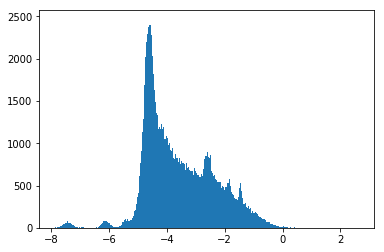

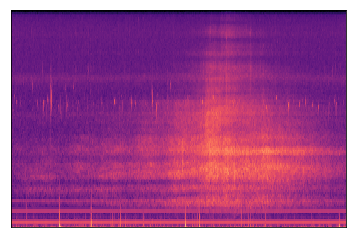

In [218]:
data_dir = '/beegfs/vl1019/BirdVox_datasets/BirdVox-pcen'
wav_names = os.listdir(data_dir)
wav_paths = sorted([os.path.join(data_dir, x) for x in wav_names])
n_files = len(wav_paths)

settings = {
    "fmin": 0,
    "fmax": 11025,
    "hop_length": 1024,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 2048,
    "window": "hann",
    "T": 0.395,#0.395,
    "alpha": 0.9,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}

file_id = 5
wav_path = wav_paths[file_id]
waveform, fs = librosa.load(wav_path, sr=22050)


# Compute Short-Term Fourier Transform (STFT).
stft = librosa.stft(
    waveform,
    n_fft=settings["n_fft"],
    win_length=settings["win_length"],
    hop_length=settings["hop_length"],
    window=settings["window"])

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
E = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=settings["sr"],
    n_fft=settings["n_fft"],
    n_mels=settings["n_mels"],
    htk=True,
    fmin=settings["fmin"],
    fmax=settings["fmax"])


E_hist = E.ravel()

%matplotlib inline
plt.figure()
plt.hist(np.log10(E_hist), bins=500);

plt.figure()
librosa.display.specshow(np.log10(E))

# 

(-2.4515449934959719, 2.5484550065040281)

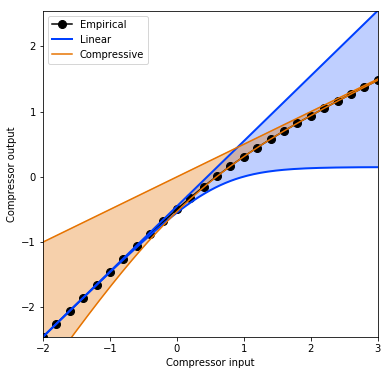

In [418]:
hop_length = settings["hop_length"]
time_constant = settings["T"]
eps = settings["eps"]
gain = settings["alpha"]
bias = settings["delta"]
power = settings["r"]
sr = settings["sr"]


b = 1 - np.exp(- float(hop_length) / (time_constant * sr))
M = scipy.signal.lfilter([b], [1, b - 1], E)
G = E * np.exp(-gain * (np.log(eps) + np.log1p(M / eps)))

G = np.logspace(-2, 4, 241)
PCEN = (G + bias)**power - bias**power

pcen_melspec = librosa.pcen(
    E, 
    sr=settings["sr"],
    hop_length=settings["hop_length"],
    gain=settings["alpha"],
    bias=settings["delta"],
    power=settings["r"],
    time_constant=settings["T"],
    eps=settings["eps"])


figsize = (6, 6)

#plt.figure(figsize=figsize)
#plt.plot(M.ravel(), E.ravel(), '.');
#plt.xlim([0.0,0.1])
#plt.ylim([0.0,0.1])

#plt.figure(figsize=figsize)
#plt.plot(M.ravel(), ((E/G).ravel()), '.');
#plt.xlim([0.0,0.09])
#plt.ylim([0.0,0.09])

plt.figure(figsize=figsize)

min_G = 10**(-2.0)
max_G = 10**(+3.0)

legend_empirical, = plt.plot(
    np.log10(G[::8]),
    np.log10(PCEN[::8]),
    'o-',
    color='k',
    markersize=8.0,
    label="Empirical");

legend_linear, = plt.plot(
    np.log10(G),
    np.log10(G * bias**(power-1) * power),
    linewidth=2.0,
    color="#0040FF",
    label="Linear")

plt.plot(
    np.log10(G),
    np.log10(np.maximum(1e-10, G * bias**(power-1) * power / (1 + (1-power)/2 * G))),
    linewidth=2.0,
    color="#0040FF")

plt.fill_between(
    np.log10(G),
    np.log10(G * bias**(power-1) * power),
    np.log10(np.maximum(1e-10, G * bias**(power-1) * power / (1 + (1-power)/2 * G))),
    alpha = 0.25,
    color="#0040FF")

legend_compressive, = plt.plot(
    np.log10(G),
    np.log10(G ** power),
    color="#E67300",
    label="Compressive")

plt.plot(
    np.log10(G),
    np.log10(np.maximum(1e-10, G**power /
                        (1 + bias/G * (power + (G/bias)**(1-power))))),
    color="#E67300")

plt.fill_between(
    np.log10(G),
    np.log10(np.maximum(1e-10, G**power /
                        (1 + bias/G * (power + (G/bias)**(1-power))))),
    np.log10(G ** power),
    alpha = 0.33,
    color="#E67300"
)


plt.legend(handles=[legend_empirical, legend_linear, legend_compressive])

plt.xlabel("Compressor input")
plt.ylabel("Compressor output")

plt.xlim([np.log10(min_G), np.log10(max_G)])
plt.ylim([np.log10(min_G * bias**(power-1) * power), np.log10(max_G * bias**(power-1) * power)])

(7, 10)

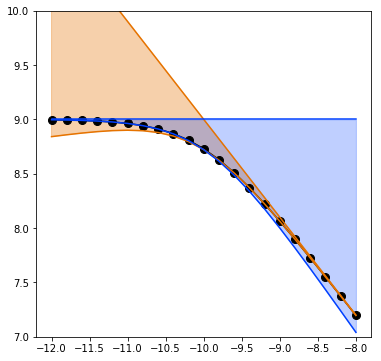

In [476]:
M = eps * np.logspace(-2, 2, 21)
denom = (M + eps)**(-gain)

plt.figure(figsize=figsize)

plt.plot(np.log10(M), np.log10(denom),
    'o-',
    color='k',
    markersize=8.0,)

plt.plot(
    np.log10(M),
    np.log10(M**(-gain)),
    color="#E67300")
plt.plot(
    np.log10(M),
    np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
    color="#E67300")
plt.fill_between(
    np.log10(M),
    np.log10(M**(-gain)),
    np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
    alpha = 0.33,
    color="#E67300"
)

plt.plot(
    np.log10(M),
    np.log10(np.ones(M.size) * eps**(-gain)),
    color="#0040FF")
plt.plot(
    np.log10(M),
    np.log10(np.maximum(1e-10,eps**(-gain) / (1 + gain*M/eps))),
    color="#0040FF")
plt.fill_between(
    np.log10(M),
    np.log10(np.ones(M.size) * eps**(-gain)),
    np.log10(np.maximum(1e-10,eps**(-gain) / (1 + gain*M/eps))),
    alpha = 0.25,
    color="#0040FF"
)
#plt.plot(np.log10(M), np.log10(np.maximum(1e-3,M**(-gain) * (1 - gain*eps/M))))

plt.ylim(7, 10)

In [443]:
(1 - gain*eps/(M**(1+gain)))

array([ -5.67861610e+12,  -2.36724119e+12,  -9.86830377e+11,
        -4.11379371e+11,  -1.71491465e+11,  -7.14895411e+10,
        -2.98018009e+10,  -1.24234584e+10,  -5.17895944e+09,
        -2.15894963e+09,  -8.99999999e+08,  -3.75182444e+08,
        -1.56402074e+08,  -6.51992354e+07,  -2.71795645e+07,
        -1.13303277e+07,  -4.72326614e+06,  -1.96898446e+06,
        -8.20808755e+05,  -3.42169457e+05,  -1.42639387e+05])

In [54]:
logmelspec = 0.5 * librosa.amplitude_to_db(melspec, ref=1.0)

%matplotlib inline
librosa.display.specshow(logmelspec)

775200

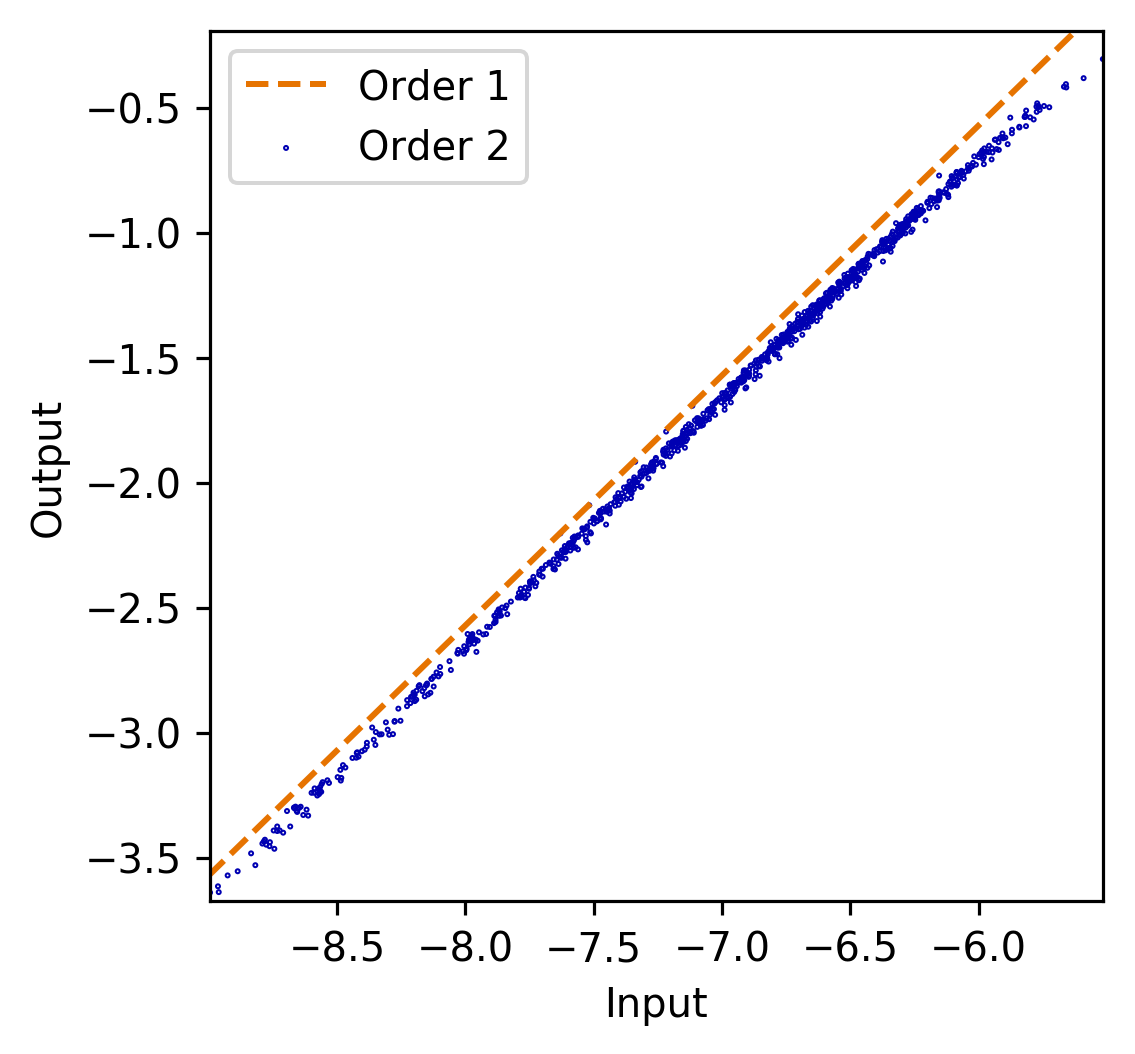

In [103]:
sr = 22050 # in Hz
T = 0.395 # in s
hop_length = 512
alpha = 0.98
delta = 2.0
r = 0.5
eps = 1e-6


n_points = 1000
half_n_points = int(n_points * 0.9)

x_eps = eps * 500.0
N = sr * 10
x = np.abs(x_eps * np.random.randn(N))[-n_points:] ** 2
y = librosa.pcen(x)[-n_points:]
b = 1 - np.exp(- float(hop_length) / (T * sr))
m = scipy.signal.lfilter([b], [1, b - 1], x)

from matplotlib import pyplot as plt
%matplotlib inline

sorting_indices = np.argsort(x)
x_sorted = x[sorting_indices]
y_sorted = y[sorting_indices]
m_sorted = m[sorting_indices]


y_th = 1.0 * x_sorted * r / ( delta**r * (eps**alpha)) #* (1 - m_sorted * alpha / eps)

y_hi = 0.5 * x_sorted * r / ( delta**r * (eps**alpha)) * (1 + 3 * (1-r)/2 * y_th / r + m_sorted * alpha / eps)
y_lo = 0.5 * x_sorted * r / ( delta**r * (eps**alpha)) * (1 - 3 * (1-r)/2 * y_th / r + 0 * m_sorted * alpha / eps)

plt.figure(figsize=(4,4), dpi=288)
plt.scatter(np.log10(x_sorted), np.log10(y_sorted),
    marker = ".", facecolor='none', s=1, edgecolors="#0000B2")
#plt.fill_between(np.log10(x_sorted), np.log10(y_th), np.log10(y_hi), alpha=0.2, color="#E67300")
#plt.fill_between(np.log10(x_sorted), np.log10(y_lo), np.log10(y_th), alpha=0.2, color="#E67300")
x_pair = np.array([x_sorted[50], x_sorted[-1]])
y_pair = x_pair * y_sorted[half_n_points]/x_sorted[half_n_points]
plt.plot(np.log10(x_sorted), np.log10(y_th), "--", color="#E67300")
plt.xlim(np.log10(x_pair))
plt.ylim(np.log10(y_pair))
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend(["Order 1", "Order 2", "Experimental"])


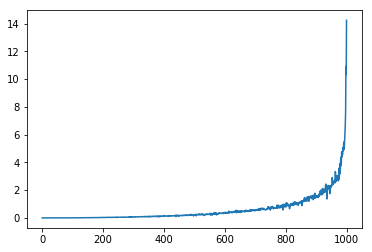

In [55]:
plt.plot(y_hi)

In [16]:
b = 1 - np.exp(- float(hop_length) / (T * sr))
ref_spec = S
scipy.signal.lfilter([b], [1, b - 1], ref_spec)

array([ 0.05709024,  0.11092118,  0.16167891, ...,  1.        ,
        1.        ,  1.        ])

In [73]:
r

0.5